# Pipeline of running CNMF-E 

In [1]:
try:
    get_ipython().magic(u'load_ext autoreload')
    get_ipython().magic(u'autoreload 2')
except:
    print('NOT IPYTHON')

import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.widgets import Slider
import caiman as cm
import caiman.source_extraction.cnmf as cnmf

## Step 1: Load data 

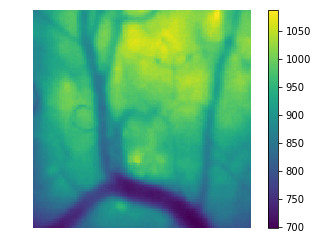

In [2]:
fname = './example_movies/data_endoscope.tif'
Y = cm.load(fname)

# OR load data in GUI mode 
# Y = neuron.ui_get_file()
plt.colorbar(plt.imshow(Y[100,]))
plt.axis('off');

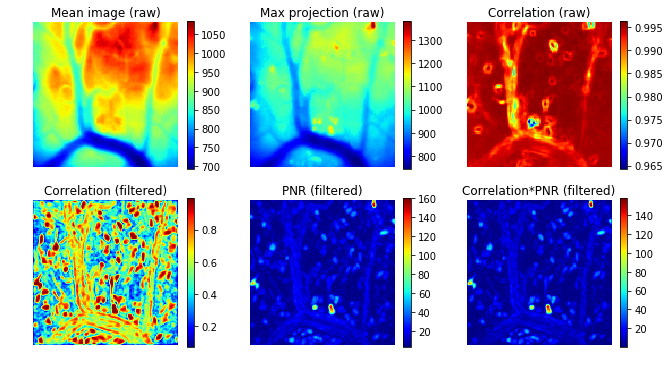

In [3]:
# show correlation image of the raw data; show correlation image and PNR image of the filtered data
cn_raw = cm.summary_images.local_correlation(Y)
cn_filter, pnr, psf = cm.summary_images.correlation_pnr_filtered(Y, gSig=1, gSiz=10, center_psf=True)
plt.figure(figsize=(11, 6))

for i, (data, title) in enumerate(((Y.mean(0), 'Mean image (raw)'),
                                   (Y.max(0), 'Max projection (raw)'),
                                   (cn_raw[1:-1,1:-1], 'Correlation (raw)'),
                                   (cn_filter, 'Correlation (filtered)'),
                                   (pnr, 'PNR (filtered)'),
                                   (cn_filter*pnr, 'Correlation*PNR (filtered)'))):
    plt.subplot(2,3,1+i)
    plt.imshow(data, cmap='jet', aspect='equal')
    plt.axis('off')
    plt.colorbar() 
    plt.title(title);

 # Step 2: initialize

<IPython.core.display.Javascript object>


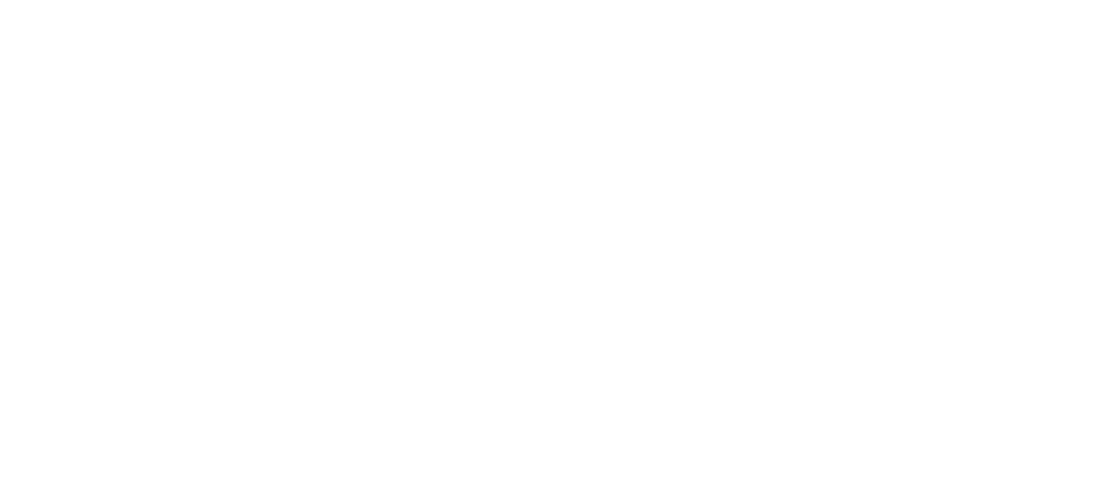

0

In [4]:
# pick thresholds 
%matplotlib notebook
fig = plt.figure(figsize=(11, 5))
plt.axes([0.05, 0.2, 0.4, 0.7])
im_cn = plt.imshow(cn_filter, cmap='jet')
plt.title('correlation image')
plt.colorbar()
plt.axes([0.5, 0.2, 0.4, 0.7])
im_pnr = plt.imshow(pnr, cmap='jet')
plt.title('PNR')
plt.colorbar();

s_cn_max = Slider(plt.axes([0.05, 0.01, 0.35, 0.03]), 'vmax', cn_filter.min(), cn_filter.max(), valinit=cn_filter.max())
s_cn_min = Slider(plt.axes([0.05, 0.07, 0.35, 0.03]), 'vmin', cn_filter.min(), cn_filter.max(), valinit=cn_filter.min())
s_pnr_max = Slider(plt.axes([0.5, 0.01, 0.35, 0.03]), 'vmax', pnr.min(), pnr.max(), valinit=pnr.max())
s_pnr_min = Slider(plt.axes([0.5, 0.07, 0.35, 0.03]), 'vmin', pnr.min(), pnr.max(), valinit=pnr.min())

def update(val):
    im_cn.set_clim([s_cn_min.val, s_cn_max.val])
    im_pnr.set_clim([s_pnr_min.val, s_pnr_max.val])
    fig.canvas.draw_idle()
s_cn_max.on_changed(update)
s_cn_min.on_changed(update)
s_pnr_max.on_changed(update)
s_pnr_min.on_changed(update)
# 'min_corr=0.85', 'min_pnr=20'

In [5]:
results = cnmf.initialization.initialize_components(Y.transpose(1,2,0), K=None, gSiz=(10, 10), gSig=(3,3), method='corr_pnr', 
                                                    center_psf=True, min_corr=0.85, min_pnr=20, ring_model=True, 
                                                    nb=10, normalize_init=False)

Noise Normalization
Roi Extraction...
0 neurons have been initialized
10 neurons have been initialized
20 neurons have been initialized
30 neurons have been initialized
40 neurons have been initialized
50 neurons have been initialized
60 neurons have been initialized
70 neurons have been initialized
80 neurons have been initialized
90 neurons have been initialized
100 neurons have been initialized
110 neurons have been initialized
120 neurons have been initialized
In total,  128 neurons were initialized.


/Users/joe/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


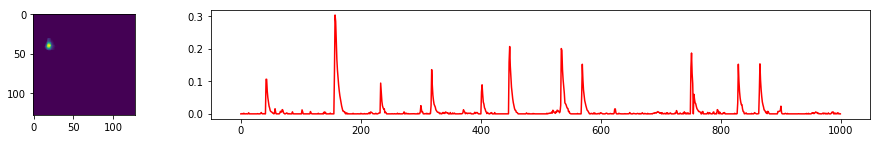

In [6]:
%matplotlib inline
# neurons
for m in range(10,11):
    f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[1, 6.5]}, figsize=(15,2))
    a0.imshow(results[0][:,m].reshape(Y.shape[1:],order='F'))
    a1.plot(results[1][m], 'r');

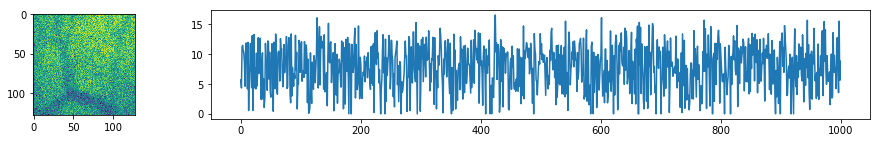

In [7]:
# background components
for m in range(1):
    f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[1, 6.5]}, figsize=(15,2))
    a0.imshow(results[2][:,m].reshape(Y.shape[1:],order='F'))
    a1.plot(results[3][m]);

In [8]:
# INIT
cnm = cnmf.CNMF(2, method_init='corr_pnr', k=None, gSig=(3,3), merge_thresh=.8,
                p=1, dview=None, Ain=None, method_deconvolution='oasis')

# Step 3: run CNMF


In [9]:
fname_new = cm.save_memmap([fname], base_name='Yr')
Yr, dims, T = cm.load_memmap(fname_new)

./example_movies/data_endoscope.tif


In [10]:
cnm.fit(Yr.T.reshape((T,) + dims, order='F'))

(1000, 128, 128)
using 2 processes
using 4000 pixels per process
using 20000 block_size
preprocessing ...
checking if missing data
Single Thread
4000
4000
4000
4000
384
initializing ...
Noise Normalization
Spatial Downsampling ...
Roi Extraction...
0 neurons have been initialized
In total,  3 neurons were initialized.
update spatial ...
Initializing update of Spatial Components
computing the distance indicators
found spatial support for each component
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
parallel dot product block size: 1000
Start product
999
1999
2999
3999
4999
5999
6999
7999
8999
9999
10999
11999
12999
13999
14999
15999
16383
--- 1.84132003784 seconds ---
Removing tempfiles created
update temporal ...
deconvolution ...
Generating residuals
parallel dot product block size: 20000
Start product
Transposing
16383
entering the deconvolution 
3 out of total 3 temporal components updated
3 out of total 3 temporal components updat

# Step 4: Visualize results


In [11]:
from bokeh.io import output_notebook, reset_output
output_notebook()  # create output within this notebook
# reset_output()  # default creates output in seperate html file
traces_fluo = cm.utils.visualization.nb_view_patches(Yr, cnm.A, cnm.C, cnm.b, cnm.f, dims[0],dims[1], denoised_color='red')

Loading BokehJS ...